## Predicting Employee Churn with Logistic Regression

## What does **`churn`** mean?


**Customer Churn**: Rate at which customers leave/cease paying for a product/service. Its a critical figure in many businesses, as acquiring new customers is a lot more costly than retaining existing ones.

**Employee Churn**: Customer churn where *customer* is the *employee* of that company. It can be used to predict who, and when an employee will terminate the service.

**GOAL**: Predict which employee will leave based on a given set of attributes

## Why Employee Churn is important?

Cons of an employee leaving the company:
- People with niche skills are important to replace
- Disrupts ongoing workflow of workers
- Incoming new employee may take time to get acquainted with the vacated role

Leveraging the power of analytics we can predict churn rate of employees, which in turn can:
- Help management design strategies accordingly
- Improve overall working environment

## Agenda

- Exploratory Data Analysis
- Data preparation
- Classification and its types
- **Problem statement**
- **Solving classification problems with linear regression**
- Building blocks of Logistic Regression
    - Odds ratio
    - **Sigmoid**
- Cost function intuition
- Model building with scikit-learn
- Evaluation metrics

## Session takeaways
- Dataset preparation
- Exploratory analysis
- Nuts and bolts of logistic regression
- Choice of evaluation metrics

## Load data with `pandas`

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# load data
df = pd.read_csv('../data/churn.csv')

# first five observations
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Shape of data and data types of features

In [5]:
# shape of data
print(df.shape)
print('='*50)

# information about data types of features
df.info()

(14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
Departments              14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Any missing values in data?

In [6]:
# check for presence of null values
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Departments              0
salary                   0
dtype: int64

## Why Employees leave in the first place?

In [8]:
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


In [9]:
pd.DataFrame(df.groupby(['left', 'salary'])['salary'].count())

salary
left salary        
0    high      1155
     low       5144
     medium    5129
1    high        82
     low       2172
     medium    1317

Employees leave because of: 
- Lower satisfaction levels
- Lower promotion rates
- Spend more time on their job
- Lesser salary

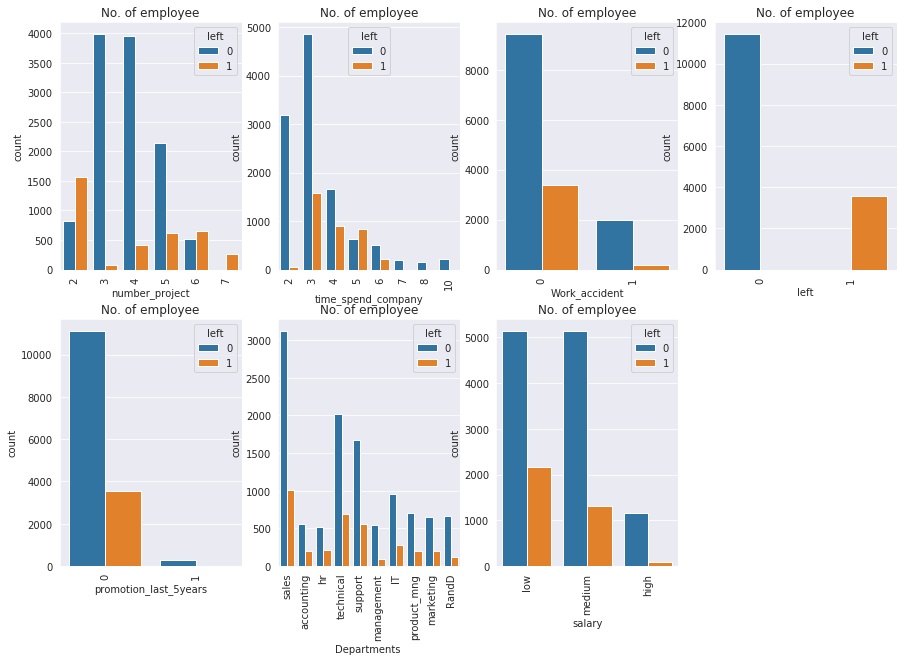

In [26]:
# Feature-wise distribution of Employees leaving vs Employees staying
features=['number_project','time_spend_company','Work_accident','left', 
          'promotion_last_5years','Departments ','salary']

fig = plt.subplots(figsize=(15,10))
for i, j in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.countplot(x=j,data = df, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

## Key takeaways

- **Less projects**: Employees with less number of projects (less than 3) are prone to leave.
- **Fatigue**: Employees with more than 5 projects are also prone to leave the organization.
- **Loyalty**: Employees with less than 3 years experience stay (time of learning) and those with more than 5 years are extremely loyal.
- **Promotion**: No promotion increases the chances of leaving
- **Departments**: `Sales`, `Technical` and `Support` teams have the highest number of employees leaving
- **Salary**: Employees with salary brackets in `low` and `medium` have higher chances of leaving

## Data Preprocessing

In [27]:
# import LabelEncoder
from sklearn import preprocessing

# creating labelEncoder object
le = preprocessing.LabelEncoder()

# Converting string labels into numbers
df['salary']=le.fit_transform(df['salary'])
df['Departments ']=le.fit_transform(df['Departments '])
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


## Split into features and target

In [28]:
# Spliting data into features and targets
X = df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Departments ', 'salary']]
y = df['left']

## Split into training and test sets

In [29]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)  
# 70% training and 30% test

## What is Classification?

- Group data according to some criteria based on attributes. Ex:
    - Predict genre of movie as **horror/suspense/thriller** based on plot, duration, actors etc.  
    - Classify emails as **spam/ham email** based on email subject, email message, attachments etc.
- `Different from regression`: Predict categories (discrete value) not continuous values. 
- Supervised learning mode; unsupervised version similar to classification also exists (clustering).

**Supervised vs Unsupervised learning**

<img src='../images/supervised.png'>

- **`Unsupervised`**: We don't know about the targets of data points and goal is to categorize data into a finite number of categories based on given features
- **`Supervised`**: Information about true targets are known (shown by colored points) and goal is predict that information (number/category) on unseen data

## Can we solve classification with linear regression?

- Technically yes!
    - Set a threshold to demarcate boundary between classes of the target variable
- No, because the decision boundary is unstable

|Without outlier | With outlier|
| --- | --- |
|<img src='../images/1.png'> | <img src='../images/2.png'> |

## Other reasons why linear regression should not be used for classification
- Target is discrete values (ex: 0/1, male/female) and not continuous
- Very prone to outliers when linear regression is used

## Solving with logistic regression
- Don't be fooled by the word **regression** at the end, it is used for classification and not regression
- First round up values between 0 and 1. How to do it? -----> **Sigmoid**

<img src='../images/sigmoid.png'>

## Is sigmoid stable?

- Max. value = 1
- Min. value = 1

<img src='../images/sig.png'>

## Odds and Odds ratio

For binary outcomes, if **`p`** is the probability of success then probability of failure is **`(1-p)`**

Odds ratio = $\mathbf{\frac{p}{1-p}}$

**Plot of odds ratio vs probability of success (p)**

<img src='../images/Odd.png'>

## Log Odds ratio

Turns out it is very hard to work with odds ratio, so we take logarithm of odds ratio. 

<img src='../images/log.png'>

## Mathematical expression of logistic regression

$y = log(\frac{p}{1-p}) = \theta_0 + \theta_1x_1 + \theta_2x_2 + .... + \theta_nx_n$

> $$ p = \frac{e^{\theta_0 + \theta_1x_1 + \theta_2x_2 + .... + \theta_nx_n}}{1 + e^{\theta_0 + \theta_1x_1 + \theta_2x_2 + .... + \theta_nx_n}}$$

> $$ p = \frac{1}{1 + e^-({\theta_0 + \theta_1x_1 + \theta_2x_2 + .... + \theta_nx_n})} $$ which is the sigmoid function

## Intuition behind cost function

$$ J(\theta)  = -\frac{1}{m}\sum_{i=1}^{m}[y_i\ln h_\theta(x_i) + (1-y_i) \ln (1-h_\theta(x_i) )]$$

**Case I**:  $y = 1$ 

The cost function becomes  $J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \ln h_\theta(x_i) $, since $ (1 - y_i) = 0$ 

**Case II**:  $y = 0$ **

Now, this cost function becomes  $J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}(1 - y_i) \ln (1 - h_\theta(x_i))$ 

<img src='../images/cost.png'>


## Model building with scikit-learn

Necessary to perform preprocessing

In [30]:
# Import LabelEncoder
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
df['salary']=le.fit_transform(df['salary'])
df['Departments ']=le.fit_transform(df['Departments '])
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1


In [31]:
# Spliting data into features and targets
X = df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Departments ', 'salary']]
y = df['left']

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)  
# 70% training and 30% test

In [32]:
# Model building

# import packages
from sklearn.linear_model import LogisticRegression

# initialize Logistic Regression model
logreg = LogisticRegression(random_state=2, class_weight={0:0.24, 1:0.76})

# Fit model on training data
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

/home/bick23/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
# Evaluate predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print('='*20)

print(accuracy_score(y_test, y_pred))
print('='*20)

print(precision_score(y_test, y_pred))
print('='*20)

print(recall_score(y_test, y_pred))
print('='*20)

print(roc_auc_score(y_test, y_pred))

[[2083  734]
 [ 190  743]]
0.7536
0.5030467163168585
0.7963558413719185
0.7678974805013657
